In [1]:
# Importing necessary libraries for image processing and visualization
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from PIL import Image

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.exposure import histogram

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

# Data preprocessing

In [2]:
# load datasets

from google.colab import drive
drive.mount('/content/drive')

# folder_path = '/content/drive/My Drive/cell_dataset/2023_11_15_Ti/'
folder_path = '/content/drive/My Drive/cell_dataset/test/'
date = '2023_11_15'

image_files = [folder_path + date + '_10x_1.0x_pLPT20&41_Ti_Pos{}.ome.tif'.format(i) for i in range(7)]
mask_files = [folder_path + 'mask_' + date + '_10x_1.0x_pLPT20&41_Ti_Pos{}.ome.tif'.format(i) for i in range(7)]
print(image_files)
print(mask_files)

Mounted at /content/drive
['/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos0.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos1.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos2.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos3.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos4.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos5.ome.tif', '/content/drive/My Drive/cell_dataset/test/2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos6.ome.tif']
['/content/drive/My Drive/cell_dataset/test/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos0.ome.tif', '/content/drive/My Drive/cell_dataset/test/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos1.ome.tif', '/content/drive/My Drive/cell_dataset/test/mask_2023_11_15_10x_1.0x_pLPT20&41_Ti_Pos2.ome.tif', '/content/drive/My Drive/cell_dataset/test/mask

In [3]:
images = np.array([imread(file) for file in image_files])
masks = np.array([imread(file) for file in mask_files])
print(images.shape)
print(masks.shape)

(7, 216, 1200, 1200, 3)
(7, 216, 1200, 1200)


In [4]:
# Normalize the images
images = images / 65535.0

In [5]:
# Manually split the dataset
train_images = images[:6]
train_masks = masks[:6]
val_images = images[6:]
val_masks = masks[6:]
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(6, 216, 1200, 1200, 3)
(6, 216, 1200, 1200)
(1, 216, 1200, 1200, 3)
(1, 216, 1200, 1200)


In [6]:
# Combine the first and second dimensions and add a channel dimension to the masks.
train_images = train_images.reshape(-1, 1200, 1200, 3)
train_masks = train_masks.reshape(-1, 1200, 1200, 1)
val_images = val_images.reshape(-1, 1200, 1200, 3)
val_masks = val_masks.reshape(-1, 1200, 1200, 1)

print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(1296, 1200, 1200, 3)
(1296, 1200, 1200, 1)
(216, 1200, 1200, 3)
(216, 1200, 1200, 1)


In [7]:
# Resize the image
def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = tf.image.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

target_size = (256, 256)
train_images = resize_images(train_images, target_size)
train_masks = resize_images(train_masks, target_size)
val_images = resize_images(val_images, target_size)
val_masks = resize_images(val_masks, target_size)

# Normalize the mask values to 0 and 1.
def binarize_masks(masks):
    masks = np.where(masks > 0, 1, 0)
    return masks

train_masks = binarize_masks(train_masks)
val_masks = binarize_masks(val_masks)

In [8]:
# Double-check the dataset shape
print(train_images.shape)
print(train_masks.shape)
print(val_images.shape)
print(val_masks.shape)

(1296, 256, 256, 3)
(1296, 256, 256, 1)
(216, 256, 256, 3)
(216, 256, 256, 1)


# Visualize the images and masks

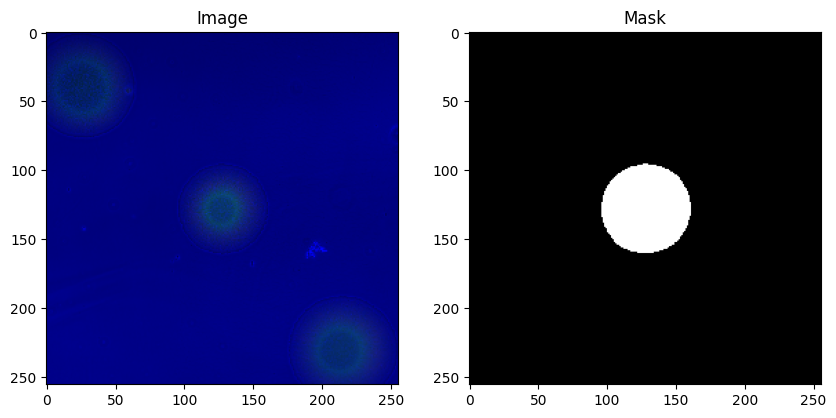

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(train_images[100], cmap='gray')
axes[0].set_title('Image')
axes[1].imshow(train_masks[100], cmap='gray')
axes[1].set_title('Mask')
plt.show()

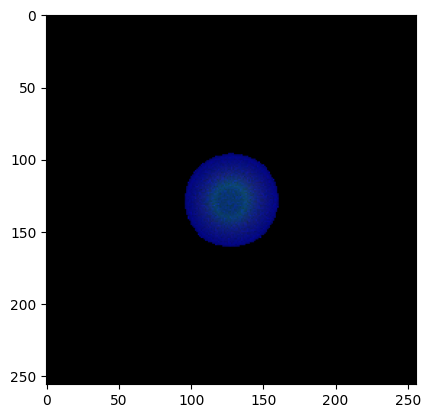

In [10]:
masked_image = np.where(train_masks[100], train_images[100], 0)
plt.imshow(masked_image, cmap='gray')

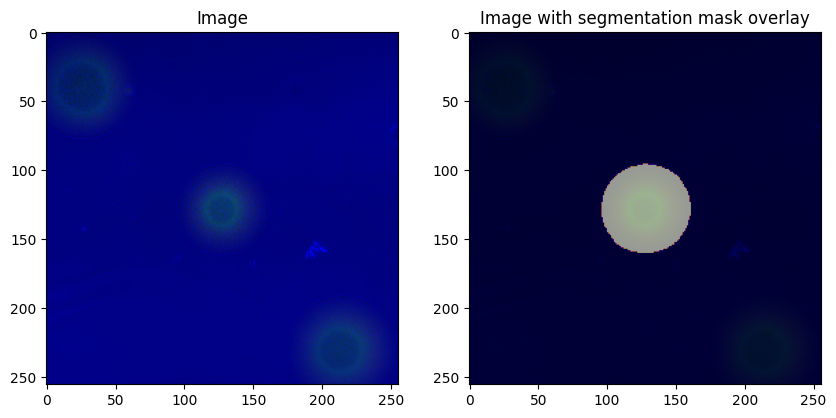

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].set_title("Image")
ax[0].imshow(train_images[100])

ax[1].set_title("Image with segmentation mask overlay")
ax[1].imshow(train_images[100])
ax[1].imshow(
    train_masks[100],
    cmap="inferno",
    alpha=0.6,
)
plt.show()

# Data augmentation strategy(test)

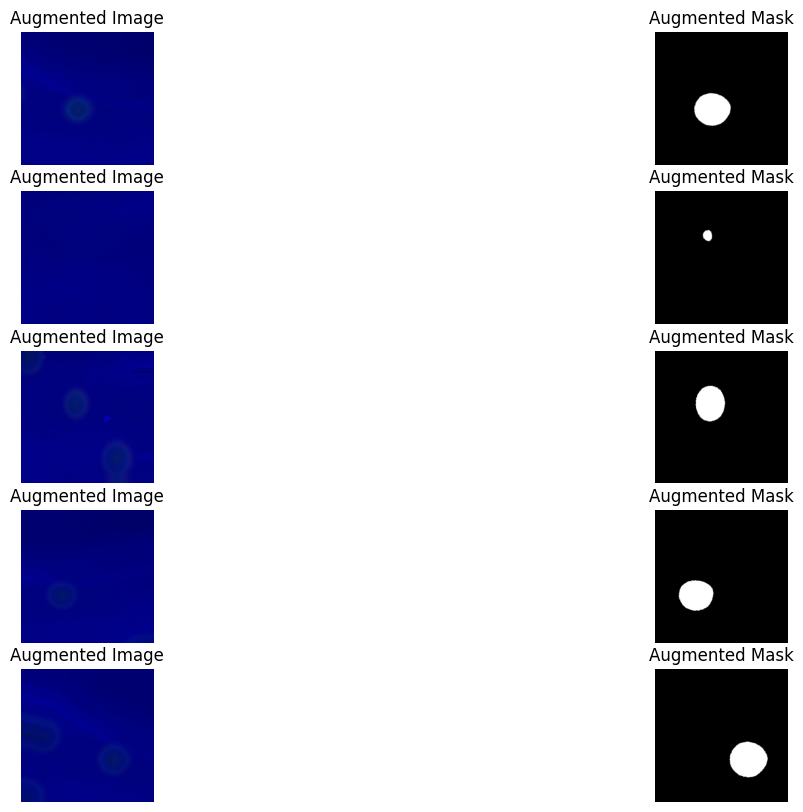

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator object
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def custom_generator(image_data, mask_data, batch_size):
    image_gen = datagen.flow(image_data, batch_size=batch_size, seed=1)
    mask_gen = datagen.flow(mask_data, batch_size=batch_size, seed=1)
    while True:
        image_batch = next(image_gen)
        mask_batch = next(mask_gen)
        yield image_batch, mask_batch

# Create the generator
train_generator = custom_generator(train_images, train_masks, batch_size=8)
validation_generator = custom_generator(val_images, val_masks, batch_size=8)

# Extract a batch of data from the generator
images_batch, masks_batch = next(train_generator)

# Visualize the original images, augmented images, and masks
def display_batch(images, masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Augmented images
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(images[i])
        plt.title('Augmented Image')
        plt.axis('off')

        # Augmented masks
        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Augmented Mask')
        plt.axis('off')

    plt.show()

# Display the augmented results of a batch
display_batch(images_batch, masks_batch)


# FCN-8s

In [29]:
# Input layer
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Use the pre-trained VGG16 as the base
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

# vgg16.summary()
block5_conv3 = vgg16.get_layer('block5_conv3').output
block4_conv3 = vgg16.get_layer('block4_conv3').output
block3_conv3 = vgg16.get_layer('block3_conv3').output

# Transposed convolution layers for upsampling
x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)
x = concatenate([x, block4_conv3])
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
x = concatenate([x, block3_conv3])
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# The final convolution layer to produce the output of the same size as the input
outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

# Define the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 256, 256, 64)   │          1,792 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 256, 256, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 128, 128, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 128, 128, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 128, 128, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 64, 64, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 64, 64, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 64, 64, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 32, 32, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 32, 32, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 32, 32, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 16, 16, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 27,656,705 (105.50 MB)

 Trainable params: 27,656,705 (105.50 MB)

 Non-trainable params: 0 (0.00 B)

# Without using a data augmentation strategy

In [27]:
# Without using a data augmentation strategy
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    batch_size=8,
                    epochs=10)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - accuracy: 0.9276 - loss: 0.1698 - val_accuracy: 0.9982 - val_loss: 0.0041
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9985 - loss: 0.0036 - val_accuracy: 0.9989 - val_loss: 0.0027
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9991 - loss: 0.0022 - val_accuracy: 0.9992 - val_loss: 0.0020
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9991 - loss: 0.0021 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9992 - loss: 0.0018 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 0.9994 - val_loss: 0.0015
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9993 - loss: 0.0016 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9994 - loss: 0.0014 - val_acc

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


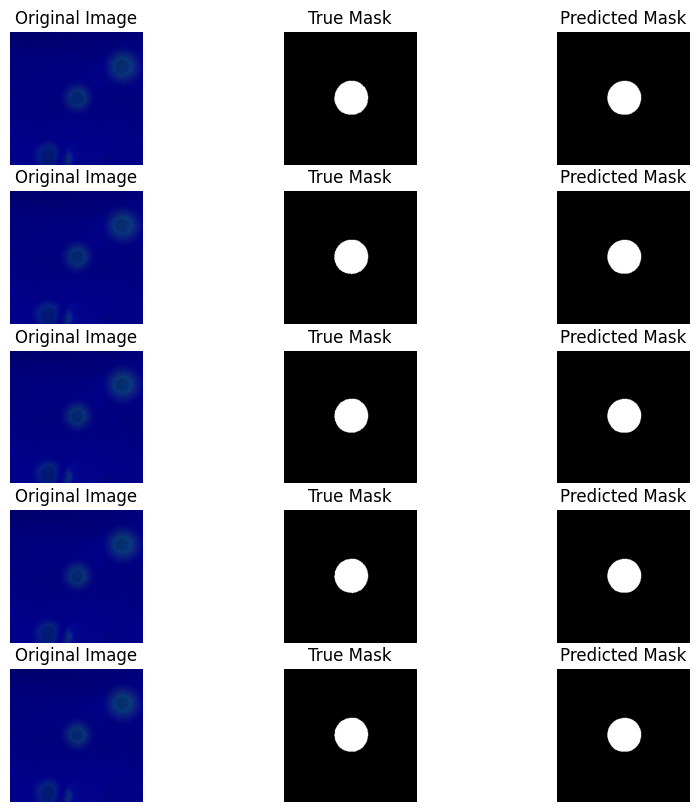

In [28]:
# Perform prediction
predicted_masks = model.predict(val_images)

# Convert the predicted values to a binary mask
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Visualize the original image and the predicted mask
def display_predictions(images, true_masks, predicted_masks, start_index=0, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = start_index + i
        if idx >= len(images):
            break

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_masks[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Display the prediction results of 5 samples starting from the 100th
display_predictions(val_images, val_masks, predicted_masks, start_index=100, num_samples=5)


# Using a data augmentation strategy

In [30]:
# Using a data augmentation strategy
history = model.fit(train_generator,
                    steps_per_epoch=len(train_images) // 8,
                    validation_data=validation_generator,
                    validation_steps=len(val_images) // 8,
                    epochs=10)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 36s 171ms/step - accuracy: 0.9546 - loss: 0.1330 - val_accuracy: 0.9687 - val_loss: 0.1070
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9470 - loss: 0.1329 - val_accuracy: 0.9681 - val_loss: 0.1234
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9468 - loss: 0.1229 - val_accuracy: 0.9623 - val_loss: 0.1771
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.9626 - loss: 0.0896 - val_accuracy: 0.9466 - val_loss: 0.4793
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.9475 - loss: 0.1589 - val_accuracy: 0.9242 - val_loss: 0.5595
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9497 - loss: 0.1539 - val_accuracy: 0.9184 - val_loss: 0.5146
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9461 - loss: 0.1337 - val_accuracy: 0.9303 - val_loss: 0.2741
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9599 - loss: 0

In [31]:
# Obtain the validation set predictions
val_predictions = model.predict(val_images)

# Convert the prediction results to binary
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(val_masks.flatten(), val_predictions_binary.flatten())

print("F1 Score on Validation Set:", f1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
F1 Score on Validation Set: 0.9757906680868467


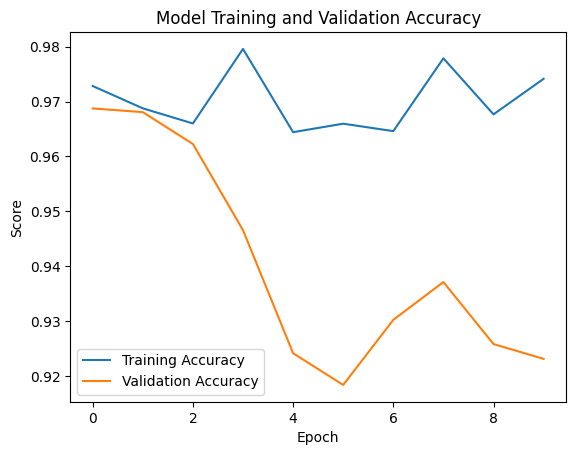

In [32]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


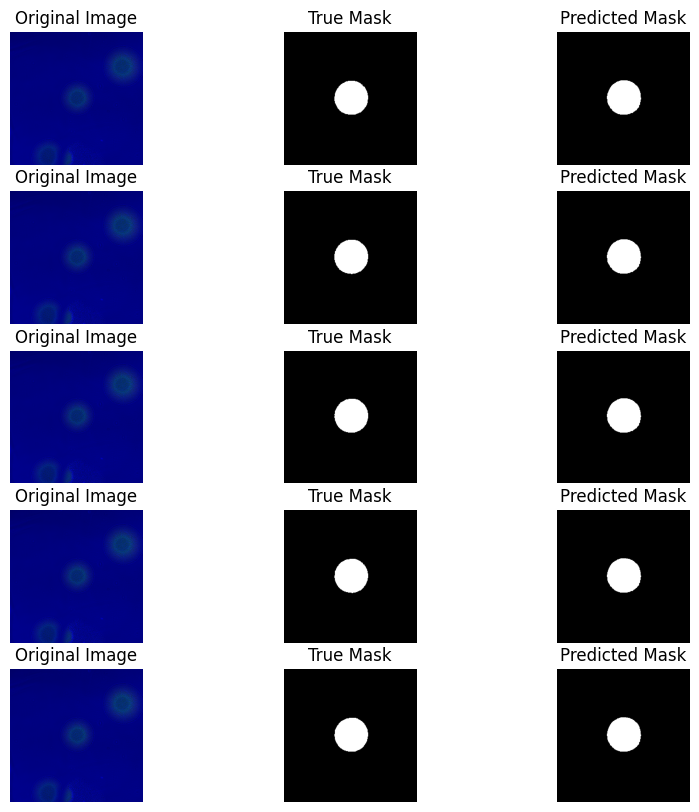

In [33]:
# Perform prediction
predicted_masks = model.predict(val_images)

# Convert the predicted values to a binary mask
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Visualize the original image and the predicted mask
def display_predictions(images, true_masks, predicted_masks, start_index=0, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = start_index + i
        if idx >= len(images):
            break

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_masks[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Display the prediction results of 5 samples starting from the 100th
display_predictions(val_images, val_masks, predicted_masks, start_index=100, num_samples=5)


# FCN-16s

In [23]:
# Pre-trained weights of the VGG16 model
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape=(256, 256, 3),
                                        include_top=False)

layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

# Obtain multi-layer outputs
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]
multi_out_model = tf.keras.models.Model(inputs=conv_base.input, outputs=layers_output)
multi_out_model.trainable = False

# Build the model
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(inputs)

# Decoder part
x1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(out)
x1 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x1)
x2 = tf.keras.layers.Add()([x1, out_block5_conv3])
x2 = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x2)
x2 = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(x2)
x3 = tf.keras.layers.Add()([x2, out_block4_conv3])
x3 = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x3)
x3 = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x3)
x4 = tf.keras.layers.Add()([x3, out_block3_conv3])
x5 = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x4)
x5 = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x5)
prediction = tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')(x5)

model = tf.keras.models.Model(inputs=inputs, outputs=prediction)

# Compile the model
fcn16s_loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=fcn16s_loss, metrics=['acc'])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ [(None, 16, 16, 512),  │     14,714,688 │ input_layer_7[0][0]    │
│                           │ (None, 32, 32, 512),   │                │                        │
│                           │ (None, 64, 64, 256),   │                │                        │
│                           │ (None, 8, 8, 512)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_11       │ (None, 16, 16, 512)    │      2,359,808 │ functional_4[0][3]     │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_transpose_11[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 16, 16, 512)    │              0 │ conv2d_10[0][0],       │
│                           │                        │                │ functional_4[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_12       │ (None, 32, 32, 512)    │      2,359,808 │ add_9[0][0]            │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_transpose_12[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 32, 32, 512)    │              0 │ conv2d_11[0][0],       │
│                           │                        │                │ functional_4[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_13       │ (None, 64, 64, 256)    │      1,179,904 │ add_10[0][0]           │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_transpose_13[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 64, 64, 256)    │              0 │ conv2d_12[0][0],       │
│                           │                        │                │ functional_4[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_14       │ (None, 128, 128, 128)  │        295,040 │ add_11[0][0]           │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_transpose_14[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_15       │ (None, 256, 256, 1)    │          1,153 │ conv2d_13[0][0]        │
│ (Conv2DTranspose)    

 Total params: 26,367,681 (100.58 MB)

 Trainable params: 11,652,993 (44.45 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Without using a data augmentation strategy

In [16]:
# Without using a data augmentation strategy
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    batch_size=8,
                    epochs=10)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - acc: 0.9419 - loss: 0.1479 - val_acc: 0.9974 - val_loss: 0.0060
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9978 - loss: 0.0056 - val_acc: 0.9982 - val_loss: 0.0040
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9986 - loss: 0.0035 - val_acc: 0.9990 - val_loss: 0.0024
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9989 - loss: 0.0026 - val_acc: 0.9987 - val_loss: 0.0030
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9991 - loss: 0.0022 - val_acc: 0.9990 - val_loss: 0.0024
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9992 - loss: 0.0020 - val_acc: 0.9992 - val_loss: 0.0020
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9992 - loss: 0.0019 - val_acc: 0.9991 - val_loss: 0.0022
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.9993 - loss: 0.0017 - val_acc: 0.9991 - val_loss: 0.0022
Epoch 9/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms

In [17]:
# Obtain the validation set predictions
val_predictions = model.predict(val_images)

# Convert the prediction results to binary
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(val_masks.flatten(), val_predictions_binary.flatten())

print("F1 Score on Validation Set:", f1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 998ms/step
F1 Score on Validation Set: 0.9877144550715014


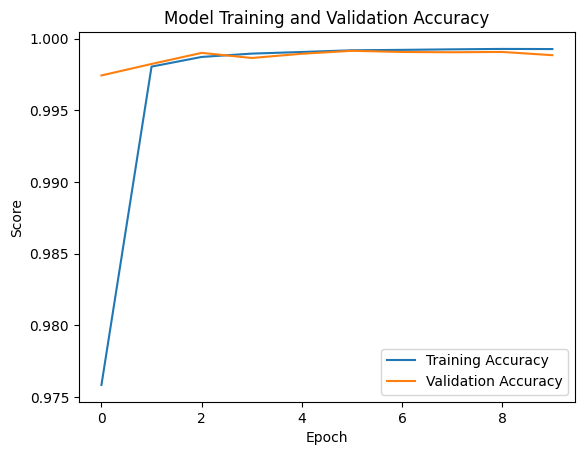

In [20]:
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


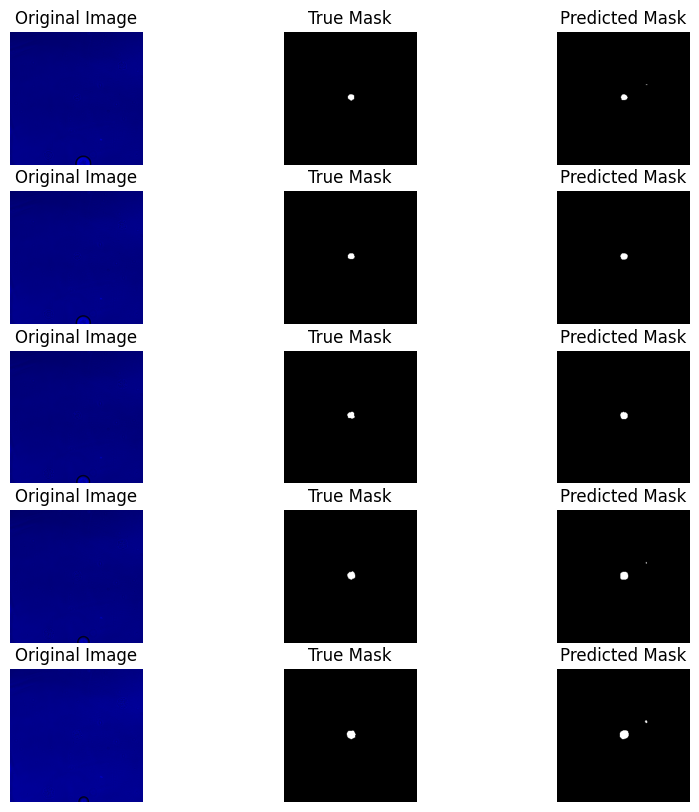

In [21]:
# Perform prediction
predicted_masks = model.predict(val_images)

# Convert the predicted values to a binary mask
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Visualize the original image and the predicted mask
def display_predictions(images, true_masks, predicted_masks, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(images[i]))
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(true_masks[i]), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(predicted_masks[i]), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# display the results
display_predictions(val_images, val_masks, predicted_masks)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


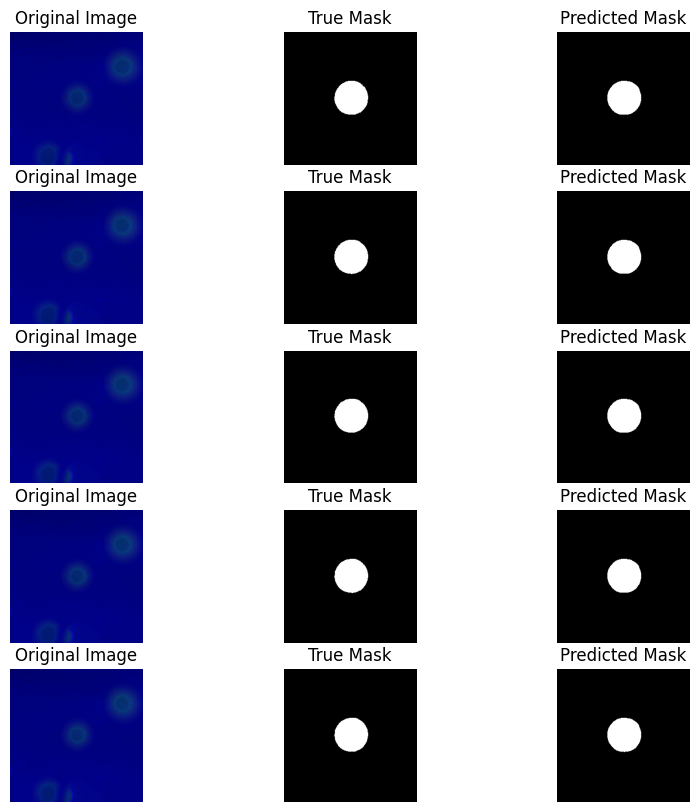

In [22]:
# Perform prediction
predicted_masks = model.predict(val_images)

# Convert the predicted values to a binary mask
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Visualize the original image and the predicted mask
def display_predictions(images, true_masks, predicted_masks, start_index=0, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = start_index + i
        if idx >= len(images):
            break

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_masks[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Display the prediction results of 5 samples starting from the 100th
display_predictions(val_images, val_masks, predicted_masks, start_index=100, num_samples=5)


# Using a data augmentation strategy

In [24]:
# Using a data augmentation strategy
history = model.fit(train_generator,
                    steps_per_epoch=len(train_images) // 8,
                    validation_data=validation_generator,
                    validation_steps=len(val_images) // 8,
                    epochs=10)

Epoch 1/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 31s 165ms/step - acc: 0.9500 - loss: 0.1421 - val_acc: 0.9684 - val_loss: 0.0792
Epoch 2/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - acc: 0.9729 - loss: 0.0723 - val_acc: 0.9713 - val_loss: 0.1120
Epoch 3/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - acc: 0.9683 - loss: 0.0861 - val_acc: 0.9643 - val_loss: 0.1602
Epoch 4/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - acc: 0.9609 - loss: 0.1153 - val_acc: 0.9311 - val_loss: 0.3530
Epoch 5/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - acc: 0.9545 - loss: 0.1334 - val_acc: 0.9208 - val_loss: 0.3325
Epoch 6/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - acc: 0.9499 - loss: 0.1351 - val_acc: 0.9229 - val_loss: 0.3708
Epoch 7/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - acc: 0.9572 - loss: 0.1160 - val_acc: 0.9259 - val_loss: 0.3738
Epoch 8/10
162/162 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - acc: 0.9589 - loss: 0.1154 - val_acc: 0.9340 - val_loss: 0.3341
Epoch 9/10
162/162 ━━━━━━━━━━━━━

In [25]:
# Obtain the validation set predictions
val_predictions = model.predict(val_images)

# Convert the prediction results to binary
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Calculate the F1 score
f1 = f1_score(val_masks.flatten(), val_predictions_binary.flatten())

print("F1 Score on Validation Set:", f1)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
F1 Score on Validation Set: 0.9502864049608492


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


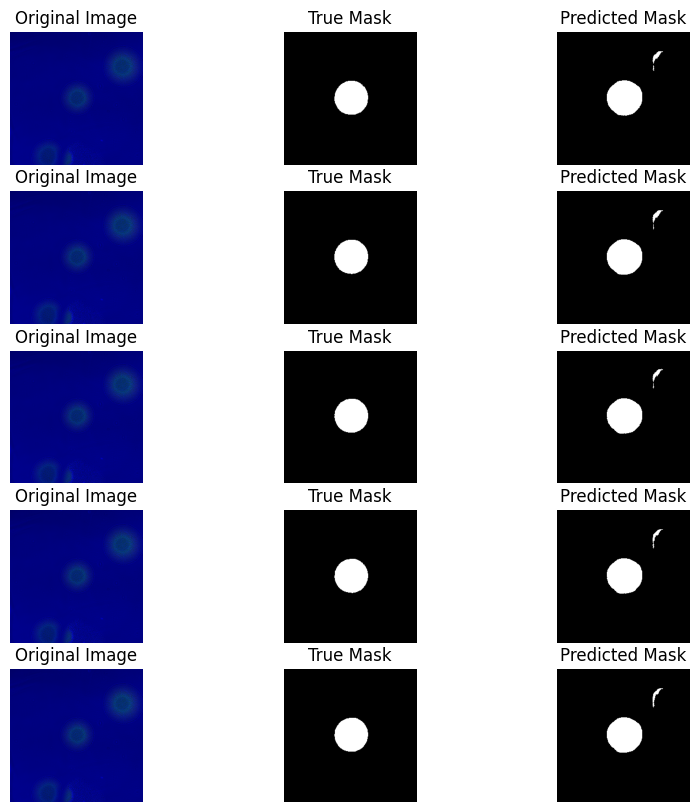

In [26]:
# Perform prediction
predicted_masks = model.predict(val_images)

# Convert the predicted values to a binary mask
threshold = 0.5
predicted_masks = (predicted_masks > threshold).astype(np.uint8)

# Visualize the original image and the predicted mask
def display_predictions(images, true_masks, predicted_masks, start_index=0, num_samples=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        idx = start_index + i
        if idx >= len(images):
            break

        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[idx])
        plt.title('Original Image')
        plt.axis('off')

        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_masks[idx].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.show()

# Display the prediction results of 5 samples starting from the 100th
display_predictions(val_images, val_masks, predicted_masks, start_index=100, num_samples=5)
